In [1]:
%load_ext autoreload
%autoreload 2

import numpy  as np
import pandas as pd
import h5py

from tqdm import tqdm
from astropy import units as u
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator
from scipy.signal      import argrelextrema

import ehtplot
import matplotlib as mpl
from matplotlib import pyplot as plt, cm

plt.rcParams.update({
#    "text.usetex": True,
#    "font.family": "serif",
#    "font.serif": ["Palatino"],
#    'mathtext.fontset': 'custom',
#    'mathtext.rm': 'Bitstream Vera Sans',
#    'mathtext.it': 'Bitstream Vera Sans:italic',
#    'mathtext.bf': 'Bitstream Vera Sans:bold',   
    'mathtext.fontset': 'stix',
    'font.family': 'STIXGeneral',
})

from common import dalt
from common import hallmark as hm
from common import mockservation as mk
from common import viz
from common import io_ipole as io

In [2]:
def readsed(f, snapshot=None):

    with h5py.File(f) as h:
        time = h['time'][:]
        nu   = h['nu'  ][:]
        knd  = h['knd' ][:]
        avg  = h['avg' ][:]
      # err  = h['err' ][:]
        rlz  = h['len' ][:]

    if not all(rlz == 16):
        print('WARNING: less than 16 realizations:', f)

    nuLnu = np.mean(avg, axis=0)
    
    return time, nu, nuLnu, [k.decode("utf-8") for k in knd]

def load(f):
    with h5py.File(f) as h:
        m    = h['meta']
        meta = dalt.ImageMeta(**{k:m[k][()] for k in m.keys()})
        data = h['data'][-16:,:,:]
    return dalt.Image(data, meta=meta)

def Fnu_to_nuLnu(nu, Fnu):
    d = 8.127e3 * u.pc
    S = 4 * np.pi * d * d
    return (Fnu*u.Jy * S * nu*u.Hz).to(u.erg/u.second).value

cmap = cm.get_cmap('afmhot_10us')

In [3]:
def mkimg(axes, a, b, c, vmax):
    #fig, axes = plt.subplots(1, 3, figsize=(12,5), sharey=True)

    mov = io.load_mov(a)
    print(np.min(mov), np.max(mov))
    viz.show(mov, s=0, ax=axes[0], cmap=cmap, vmin=0)
    axes[0].set_xlim( 99.99,-99.99)
    axes[0].set_ylim(-99.99, 99.99)

    mov = io.load_mov(b)
    print(np.min(mov), np.max(mov))
    viz.show(mov, s=0, ax=axes[1], cmap=cmap, vmin=0)
    axes[1].set_xlim( 99.99,-99.99)
    axes[1].set_ylim(-99.99, 99.99)
    axes[1].set_ylabel(None)

    mov = io.load_mov(c)
    print(np.min(mov), np.max(mov))
    viz.show(mov, s=0, ax=axes[2], cmap=cmap, vmin=0)
    axes[2].set_xlim( 99.99,-99.99)
    axes[2].set_ylim(-99.99, 99.99)
    axes[2].set_ylabel(None)
    
    for ax in axes:
        ax.tick_params(
            axis='both',
            direction='in',
            top=True,
            right=True,
            color='w',
        )
        for spine in ax.spines.values():
            spine.set_edgecolor('w')

In [4]:
from astropy.io import fits
from astropy import units as u
from common import dalt as d

with fits.open('model/Frankfurt_thermal/86GHz/SANE/a0.50_i030_R040/SgrA_SANE_a0.50_i029_Rh040_Rl01_sigc01_snorm2.4_t30000_f086GHz_hres.fits') as hdul:
    img = hdul[0].data
img86 = d.Image(img.T, 4.14e6 * u.Msun, 2.5077305106e+22 * u.cm, 86e9 * u.H, 0,
                200 * u.uas.to(u.rad) * 2.5077305106e+22 * u.cm,
                200 * u.uas.to(u.rad) * 2.5077305106e+22 * u.cm)

with fits.open('model/Frankfurt_thermal/SANE20-30kM/a0.50_i030_R040/SgrA_SANE_a0.50_i029_Rh040_Rl01_sigc01_snorm2.4_t30000_f230GHz.fits') as hdul:
    img = hdul[0].data
img230 = d.Image(img.T, 4.14e6 * u.Msun, 2.5077305106e+22 * u.cm, 86e9 * u.H, 0,
                 200 * u.uas.to(u.rad) * 2.5077305106e+22 * u.cm,
                 200 * u.uas.to(u.rad) * 2.5077305106e+22 * u.cm)

In [5]:
from astropy import constants as c

nu1 = 86e9 * u.Hz # input image may have this information
scale1 = c.c**2 / (2 * c.k_B * nu1**2) * u.rad**2
vmax1 = 30e9

nu2 = 227070703125.0 * u.Hz # input image may have this information
scale2 = c.c**2 / (2 * c.k_B * nu2**2) * u.rad**2
vmax2 = 15e9

-7.852375867707764e-286 erg / (cm2 Hz s sr) 0.00016367251039718875 erg / (cm2 Hz s sr)
0.0 erg / (cm2 Hz s sr) 0.0002011808894411461 erg / (cm2 Hz s sr)
0.0 erg / (cm2 Hz s sr) 0.0002011808894411461 erg / (cm2 Hz s sr)
1.4144983468108892e-09 erg / (cm2 Hz s sr) 0.0007133607617140331 erg / (cm2 Hz s sr)
0.0 erg / (cm2 Hz s sr) 0.0007846856817219067 erg / (cm2 Hz s sr)
0.0 erg / (cm2 Hz s sr) 0.0007846856817219067 erg / (cm2 Hz s sr)
Bbox(x0=0.6458554083885208, y0=0.5025, x1=0.8975220750551876, y1=0.88)


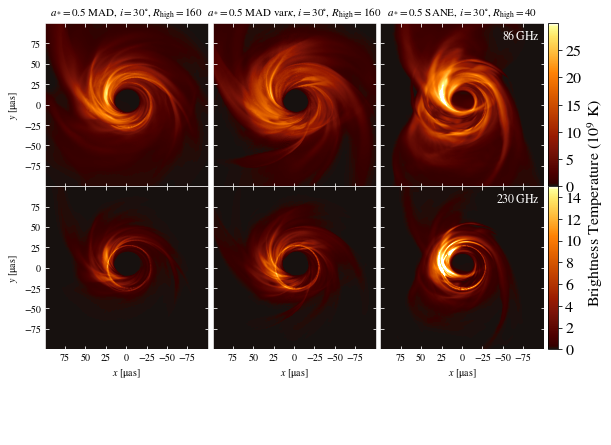

In [14]:
fig, axes = plt.subplots(2,3, figsize=(9,6), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0, wspace=0.01)

mkimg(axes[0],
#    'model/Illinois_thermal/86GHz/Ma+0.5_w5/img_s05999_Rh160_i30.h5',
    'model/Illinois_thermal/86GHz/Ma+0.5_w5/img_s05999_Rh160_i30_hres.h5',
    'model/Hamr_varkappa/86GHz/mad_a+0.5/Rhigh_160_Inclination_30/mad_a+5_3487.h5',
    'model/Hamr_varkappa/86GHz/mad_a+0.5/Rhigh_160_Inclination_30/mad_a+5_3487.h5',
#    'model/Frankfurt_thermal/SANE20-30kM/a0.94_i030_R040/SgrA_SANE_a0.94_i029_Rh040_Rl01_sigc01_snorm2.4_t30000_f86GHz.fits',
    2e-4,
)

mkimg(axes[1],
    'model/Illinois_thermal/230GHz/Ma+0.5_w5/img_s05999_Rh160_i30.h5',
    'model/Hamr_varkappa/230GHz/mad_a+0.5/Rhigh_160_Inclination_30/mad_a+5_3487.h5',
    'model/Hamr_varkappa/230GHz/mad_a+0.5/Rhigh_160_Inclination_30/mad_a+5_3487.h5',
#    'model/Frankfurt_thermal/SANE20-30kM/a0.94_i030_R040/SgrA_SANE_a0.94_i029_Rh040_Rl01_sigc01_snorm2.4_t30000_f230GHz.fits',
    2e-4,
)

viz.show(img86,
         f=lambda img: (img * scale1).to(u.K),
         ax=axes[0,2], cmap='afmhot_10us', vmin=0, vmax=vmax1)
viz.show(img230,
         f=lambda img: (img * scale2).to(u.K),
         ax=axes[1,2], cmap='afmhot_10us', vmin=0, vmax=vmax2)

axes[0,0].set_title('$a_*\!=0.5$ MAD, $i=30^{\circ}$, $R_\mathrm{high}=160$',             fontsize=11)
axes[0,1].set_title('$a_*\!=0.5$ MAD var$\kappa$, $i=30^{\circ}$, $R_\mathrm{high}=160$', fontsize=11)
axes[0,2].set_title('$a_*\!=0.5$ SANE, $i=30^{\circ}$, $R_\mathrm{high}=40$',             fontsize=11)
axes[0,2].text(-95,80, '$86\,\mathrm{GHz}$',  color='w', fontsize=12, horizontalalignment='right')
axes[1,2].text(-95,80, '$230\,\mathrm{GHz}$', color='w', fontsize=12, horizontalalignment='right')
axes[1,0].set_xticks(range(75,-99,-25))
axes[1,1].set_xticks(range(75,-99,-25))
axes[1,2].set_xticks(range(75,-99,-25))

axes[0,1].set_ylabel(None)
axes[0,2].set_ylabel(None)
axes[1,1].set_ylabel(None)
axes[1,2].set_ylabel(None)

pos1 = axes[0,2].get_position()
pos2 = axes[1,2].get_position()
print(pos1)

cbaxes = fig.add_axes([pos1.x1+0.0075, pos1.y0, 0.015, pos1.y1-pos1.y0])
cbar = fig.colorbar(cm.ScalarMappable(mpl.colors.Normalize(0,30), cmap='afmhot_10us'), ticks=np.arange(0, 30, 5), orientation="vertical", cax=cbaxes)
cbar.ax.tick_params(labelsize=16)

cbaxes = fig.add_axes([pos2.x1+0.0075, pos2.y0, 0.015, pos2.y1-pos2.y0])
cbar = fig.colorbar(cm.ScalarMappable(mpl.colors.Normalize(0,15), cmap='afmhot_10us'), ticks=np.arange(0, 15, 2), orientation="vertical", cax=cbaxes)
cbar.ax.tick_params(labelsize=16)
cbar.set_label(label="                                 Brightness Temperature ($10^9$ K)", size=16)

fig.savefig('output/example_imgs.pdf', bbox_inches='tight')

In [7]:
def mksed(a, at, b, bt, c, ct, out):
    fig, axes = plt.subplots(1, 3, figsize=(12,4.8), sharey=True)
    plt.subplots_adjust(hspace=0, wspace=0.01)

    time, nu, nuLnu, knd = readsed(a)
    viz.step(axes[0], nu, nuLnu, label=knd)
    axes[0].set_xlim(1e9,  1e23)
    axes[0].set_ylim(1e27, 1e37)
    axes[0].set_xlabel(r'$\nu$ [Hz]')
    axes[0].set_ylabel(r'$\nu L_\nu$ [erg/s]')
    axes[0].set_title(at)
    axes[0].errorbar(
        [86e9, 230e9, 1.4141e+14, 1.45e18], 
        [Fnu_to_nuLnu(86e9,1.9), Fnu_to_nuLnu(230e9,2.4), Fnu_to_nuLnu(1.4141e+14,1e-3), 1e33],
        yerr=[Fnu_to_nuLnu(86e9,0.2), 0, Fnu_to_nuLnu(1.4141e+14,1e-3)/2, 1e33/2],
        uplims=[False,False,True,True],
        fmt='o', color='k',
    )    

    time, nu, nuLnu, knd = readsed(b)
    # Fix mislabel
    print(knd, nuLnu.shape)
    nuLnu[:70,1] += nuLnu[:70,5]
    nuLnu[:70,5]  = 0
    print(knd, nuLnu.shape)
    nuLnu[:100,2] += nuLnu[:100,6]
    nuLnu[:100,6]  = 0
    viz.step(axes[1], nu, nuLnu, label=knd)
    axes[1].set_xlim(1e9,  1e23)
    axes[1].set_ylim(1e27, 1e37)
    axes[1].set_xlabel(r'$\nu$ [Hz]')
    axes[1].set_title(bt)
    axes[1].errorbar(
        [86e9, 230e9, 1.4141e+14, 1.45e18], 
        [Fnu_to_nuLnu(86e9,1.9), Fnu_to_nuLnu(230e9,2.4), Fnu_to_nuLnu(1.4141e+14,1e-3), 1e33],
        yerr=[Fnu_to_nuLnu(86e9,0.2), 0, Fnu_to_nuLnu(1.4141e+14,1e-3)/2, 1e33/2],
        uplims=[False,False,True,True],
        fmt='o', color='k',
    )
    
    time, nu, nuLnu, knd = readsed(c)    
    viz.step(axes[2], nu, nuLnu, label=knd)
    axes[2].set_xlim(1e9,  1e23)
    axes[2].set_ylim(1e27, 1e37)
    axes[2].set_xlabel(r'$\nu$ [Hz]')
    axes[2].set_title(ct)
    axes[2].errorbar(
        [86e9, 230e9, 1.4141e+14, 1.45e18], 
        [Fnu_to_nuLnu(86e9,1.9), Fnu_to_nuLnu(230e9,2.4), Fnu_to_nuLnu(1.4141e+14,1e-3), 1e33],
        yerr=[Fnu_to_nuLnu(86e9,0.2), 0, Fnu_to_nuLnu(1.4141e+14,1e-3)/2, 1e33/2],
        uplims=[False,False,True,True],
        fmt='o', color='k',
    )    
    
    for ax in axes:
        ax.tick_params(
            axis='both',
            direction='in',
            top=True,
            right=True)
    
    fig.tight_layout()
    axes[0].legend(ncol=3, loc='lower left', bbox_to_anchor=(-0.015, 1.08))

    fig.savefig(out, bbox_inches='tight')

['total', '(synch) base', '(synch) once', '(synch) twice', '(synch) > twice', '(brems) base', '(brems) once', '(brems) twice', '(brems) > twice'] (200, 9)
['total', '(synch) base', '(synch) once', '(synch) twice', '(synch) > twice', '(brems) base', '(brems) once', '(brems) twice', '(brems) > twice'] (200, 9)


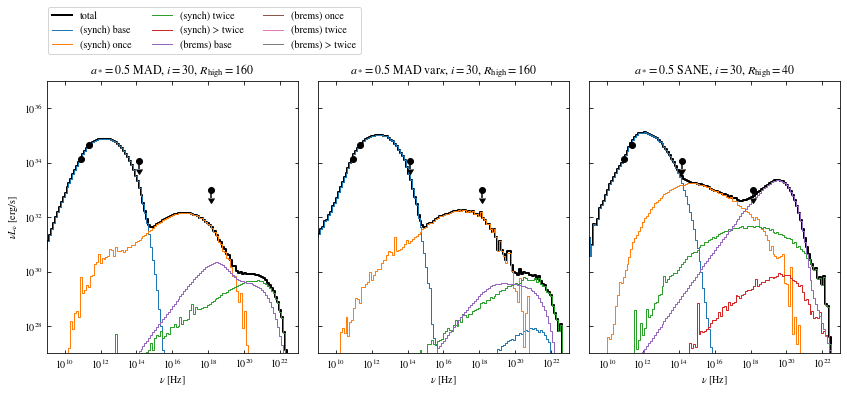

In [8]:
mksed(
    'cache/Illinois_thermal_w5/Ma+0.5_i30/sed_Rh160.h5',
    '$a_*=0.5$ MAD, $i=30$, $R_\mathrm{high}=160$',

    'cache/Hamr_varkappa/mad_a0.5_i30/sed_Rh160.h5',
    '$a_*=0.5$ MAD var$\kappa$, $i=30$, $R_\mathrm{high}=160$',

    'cache/Illinois_thermal_w5/Sa+0.94_i30/sed_Rh40.h5',
    '$a_*=0.5$ SANE, $i=30$, $R_\mathrm{high}=40$',
    
    'output/sample_seds.pdf',
)

In [9]:
nmin = 2.5e9
nmax = 3.5e9

bmin = 6e9
bmax = 8e9

def mkoneva(ax, a, tx):
    mov = load(a)
    vis = mk.mockserve(mov, N=512)

    U, V = vis.uvd
    u = np.linspace( 0,   U/2, num=vis.shape[-1])
    v = np.linspace(-V/2, V/2, num=vis.shape[-2], endpoint=False)
    t = vis.meta.time.value

    amp = RegularGridInterpolator((t[-16:], v, u[::-1]), abs     (vis[...,::-1]))
  # phi = RegularGridInterpolator((t, v, u[::-1]), np.angle(vis[...,::-1]))
    uvd = np.linspace(0, 1.1e10, round(1e10/1e7)+1)
    
    ax.axvspan(nmin/1e9, nmax/1e9, color='k', alpha=1/10, edgecolor=None)
    ax.axhspan(0, 0.04/0.5, color='k', alpha=1/10)

    for i in range(-90,90,45):
        phi = np.pi * i / 180
        u   = uvd * np.cos(phi)
        v   = uvd * np.sin(phi)

        mask = u <= 0
        p = np.array([np.repeat(t[-1], np.sum( mask)),  v[ mask],  u[ mask]]).T
        m = np.array([np.repeat(t[-1], np.sum(~mask)), -v[~mask], -u[~mask]]).T
    
        s = np.zeros(len(uvd))
        s[ mask] = amp(p)
        s[~mask] = amp(m)
        
        label = f'PA=${i}\degree$'
        if i == -90:
            label += ' (horizontal)'
        elif i == 0:
            label += ' (vertical)'
        p = ax.semilogy(uvd/1e9, s/s[0], label=label)#, ':' if i < 0 else '-')
        
        lc = argrelextrema(s, np.less)[0]
        ax.scatter(uvd[lc]/1e9, s[lc]/s[0], color=p[0].get_color())
        
        la = np.median(s[(bmin <= uvd) & (uvd <= bmax)])
        ax.plot([bmin/1e9, bmax/1e9], [la/s[0], la/s[0]], ':', color=p[0].get_color())

    ax.text(2, 0.8, tx, fontsize=12)
    ax.set_xlim(-0.5, 10.5)
    ax.set_ylim(0.1/12, 0.1*12)
    ax.set_xlabel('$u$-$v$ distance [G$\lambda$]')

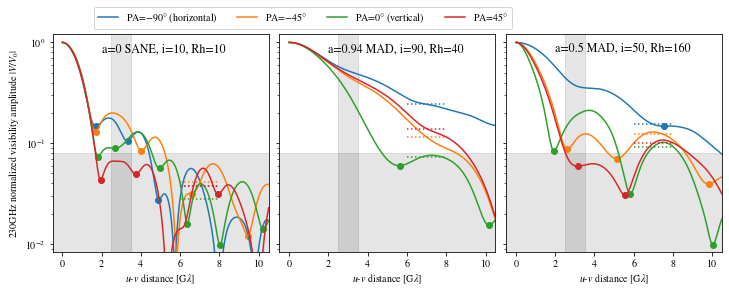

In [10]:
fig, axes = plt.subplots(1,3, figsize=(12,4), sharey=True)#, xpan)
fig.subplots_adjust(wspace=0.05, hspace=0)

mkoneva(axes[0], 
        'cache/Illinois_thermal_w5/Sa0_i10/gt_Rh10_230GHz.h5',
        'a=0 SANE, i=10, Rh=10')
mkoneva(axes[1],
        'cache/Illinois_thermal_w5/Ma+0.94_i90/gt_Rh40_230GHz.h5',
        'a=0.94 MAD, i=90, Rh=40')
mkoneva(axes[2],
        'cache/Hamr_varkappa/sane_a0.5_i50/gt_Rh160_230GHz.h5',
        'a=0.5 MAD, i=50, Rh=160')

axes[0].set_ylabel('230GHz normalized visibility amplitude $|V/V_0|$')
axes[0].legend(ncol=4, bbox_to_anchor=(2.15, 1.15))

fig.savefig('output/sample_va.pdf', bbox_inches='tight')